## Notebook for viewing and testing inclusive plots

### Plots included
### - Closure Test (from 2DAlphabet output)
### -  ttbar mass with signals
### - Transfer function
### - Closure Test from processor --- work in progress
### - QCD Closure Test from processor --- work in progress

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
hep.style.use("CMS")
from coffea import util
import itertools
import os, sys
import glob
import copy
from scipy.optimize import curve_fit
import uproot

sys.path.append('../python/')
import functions

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Initialize

In [2]:

IOV = '2018'


# scale factors and luminosity

lumi = functions.lumi
rsgluon_xs = functions.rsgluon_xs



# initialize

functions.makeSaveDirectories()

        
# binsize = 1/np.diff(hbkg.axes['ttbarmass'].edges)[0]
binsize = 10

blind = True
lumifactor = 0.1 if blind else 1.0

label_map = functions.getLabelMap()
label_to_int = {label: i for i, label in label_map.items()}

signal_cats = [ i for label, i in label_to_int.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int.items() if 'pre' in label]
antitag_cats = [ i for label, i in label_to_int.items() if 'at' in label]


lines_dict = {'solid': 'solid',
 'dotted': (0, (1, 1)),
 'dashed': (0, (5, 5)),
 'dashdot': 'dashdot',
 'loosely dotted': (0, (1, 10)),
 'densely dotted': (0, (1, 1)),
 'long dash with offset': (5, (10, 3)),
 'loosely dashed': (0, (5, 10)),
 'densely dashed': (0, (5, 1)),
 'loosely dashdotted': (0, (3, 10, 1, 10)),
 'dashdotted': (0, (3, 5, 1, 5)),
 'densely dashdotted': (0, (3, 1, 1, 1)),
 'dashdotdotted': (0, (3, 5, 1, 5, 1, 5)),
 'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
 'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1))}

lines = list(lines_dict.values())


# categories and systematics labels

cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']

systematics = ['nominal', 'jes', 'jer', 'pileup', 'pdf', 'q2', 'btag', 'prefiring']
syst_labels = ['nominal']
for s in systematics:
    if not 'nominal' in s:
        syst_labels.append(s+'Down')
        syst_labels.append(s+'Up')

        

## functions

In [3]:
def getUncertainy(hbkg, hUnc):
    
    axes_systematics = hUnc.axes['systematic']
    
    nomvals = hbkg.values()

    for syst in axes_systematics:

        if 'Up' in syst:

            upvals = (1 + np.abs(nomvals - hUnc[{'systematic':syst}].values())/nomvals)

        elif 'Down' in syst:

            downvals = (1 - np.abs(nomvals - hUnc[{'systematic':syst}].values())/nomvals)
            
    return hbkg*upvals, hbkg*downvals



# transfer function
def rpf(x, y, p):
    
    scale = ( p[0] + p[1]*x + p[2]*x*x + p[3]*x*x*x ) * ( 1 + p[4]*y ) 

    return np.abs(scale)
    
    
    
    
    
    
    


## Closure Test
### using output root file (`all_plots.root`) from 2DAlphabet
- root file copied from lxplus in `ttbar-{signal}/plots_fit_b/all_plots.root` to `plots/` directory
- saved as `all_plots_2016.root`, `all_plots_2017.root`, `all_plots_2018.root` for corresponding years

### ttbarmass

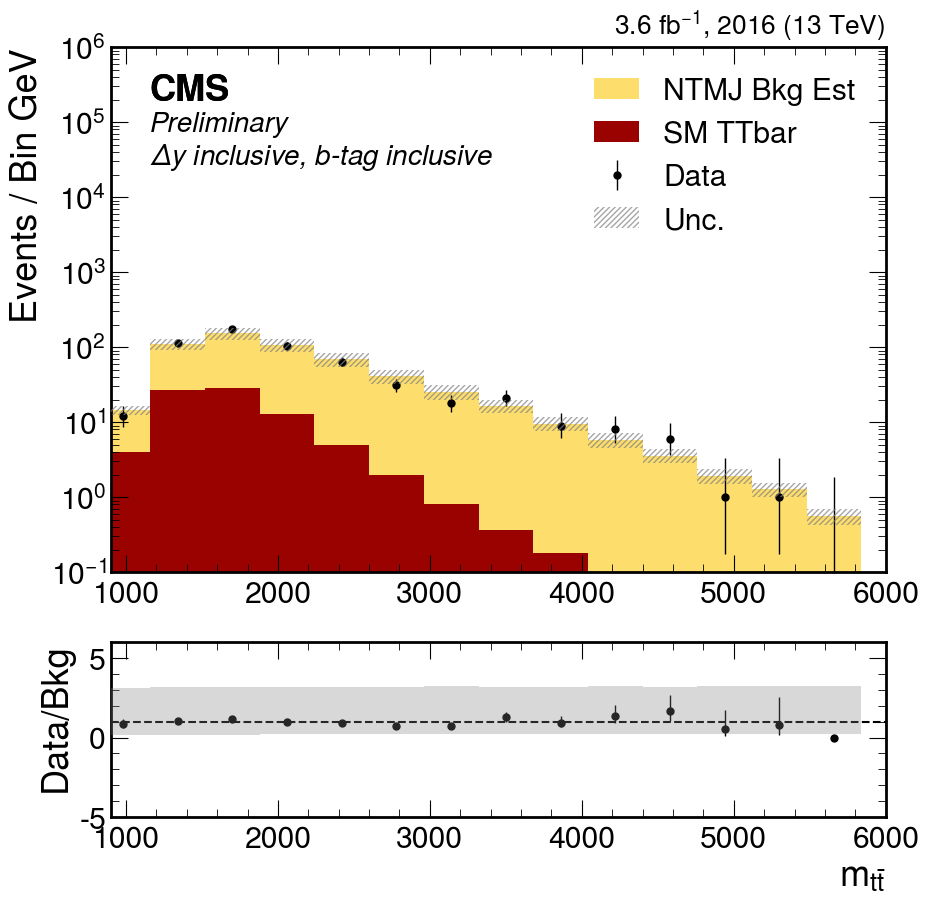

In [4]:
IOV = '2016all'

ttbar_str = IOV.replace('20','').replace('all','')

f = uproot.open(f'all_plots_{IOV.replace("all","")}.root')

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

hbkg0 = f['TotalBkg_Pass_postfit_projy0;1']
httbar0 = f[ttbar_str+'_TTbar_Pass_postfit_projy0;1']
hdata0 = f['data_obs_Pass_postfit_projy0;1']


hbkg1 = f['TotalBkg_Pass_postfit_projy1;1']
httbar1 = f[ttbar_str+'_TTbar_Pass_postfit_projy1;1']
hdata1 = f['data_obs_Pass_postfit_projy1;1']

hbkg2 = f['TotalBkg_Pass_postfit_projy2;1']
httbar2 = f[ttbar_str+'_TTbar_Pass_postfit_projy2;1']
hdata2 = f['data_obs_Pass_postfit_projy2;1']

hbkg_plots = hbkg0.to_hist() + hbkg1.to_hist() + hbkg2.to_hist()
httbar_plots = httbar0.to_hist() + httbar1.to_hist() + httbar2.to_hist()
hdata_plots = hdata0.to_hist() + hdata1.to_hist() + hdata2.to_hist()


# errors 
errs = np.sqrt(hbkg_plots.variances())

height = errs * 2
bottom = hbkg_plots.values() - errs
edges = hbkg_plots.axes['xaxis'].edges


text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hdata_plots, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hbkg_plots, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar_plots, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)





ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
ratioUp = 1 + errs / hbkg_plots.values()
ratioDn = 1 - errs / hbkg_plots.values()


ax2.bar(x = edges[:-1],
           height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
           bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
           width = np.diff(edges), align='edge', edgecolor='gray',
           linewidth=0, facecolor='gray', alpha=0.3,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(-5,6)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax2.set_xlabel(r'$m_{t\bar{t}}$')

ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e6)
ax1.set_xlim(900,6000)
ax2.set_xlim(900,6000)
ax1.set_xlabel('')


del f



### jet mass

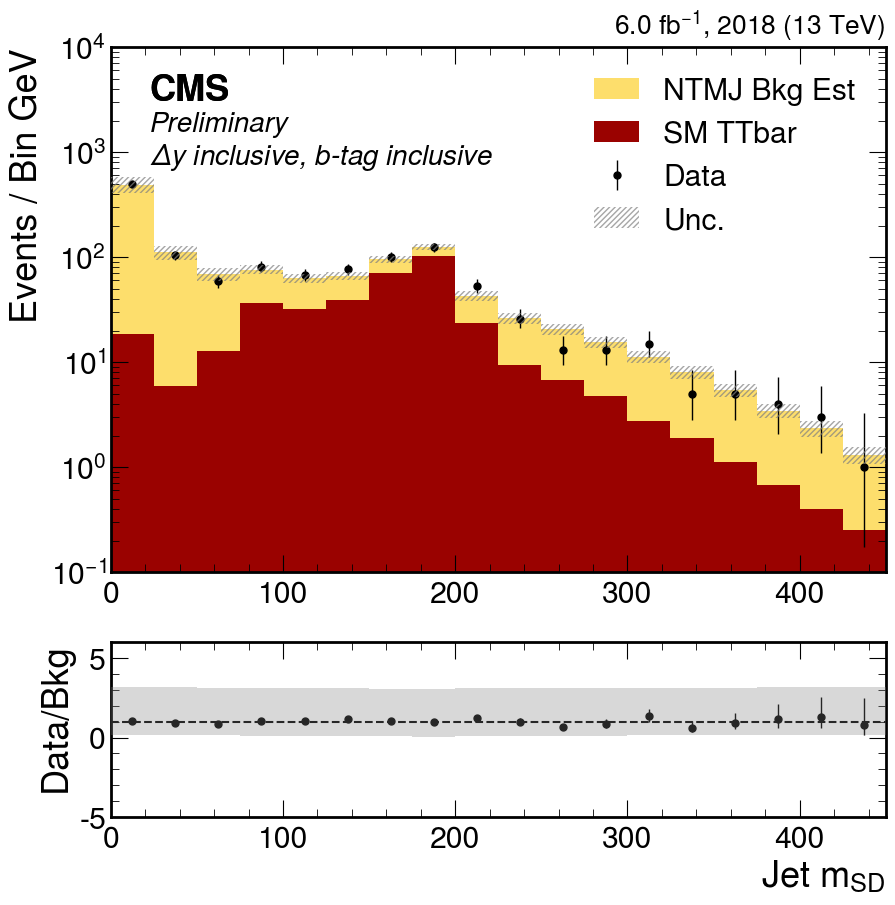

In [5]:
IOV = '2016all'
IOV = '2017'
IOV = '2018'

ttbar_str = IOV.replace('20','').replace('all','')

f = uproot.open(f'all_plots_{IOV.replace("all","")}.root')

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

hbkg0 = f['TotalBkg_Pass_postfit_projx0;1']
httbar0 = f[ttbar_str+'_TTbar_Pass_postfit_projx0;1']
hdata0 = f['data_obs_Pass_postfit_projx0;1']


hbkg1 = f['TotalBkg_Pass_postfit_projx1;1']
httbar1 = f[ttbar_str+'_TTbar_Pass_postfit_projx1;1']
hdata1 = f['data_obs_Pass_postfit_projx1;1']

hbkg2 = f['TotalBkg_Pass_postfit_projx2;1']
httbar2 = f[ttbar_str+'_TTbar_Pass_postfit_projx2;1']
hdata2 = f['data_obs_Pass_postfit_projx2;1']

hbkg_plots = hbkg0.to_hist() + hbkg1.to_hist() + hbkg2.to_hist()
httbar_plots = httbar0.to_hist() + httbar1.to_hist() + httbar2.to_hist()
hdata_plots = hdata0.to_hist() + hdata1.to_hist() + hdata2.to_hist()


# errors 
errs = np.sqrt(hbkg_plots.variances())

height = errs * 2
bottom = hbkg_plots.values() - errs
edges = hbkg_plots.axes['xaxis'].edges


text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hdata_plots, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hbkg_plots, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar_plots, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)





ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
ratioUp = 1 + errs / hbkg_plots.values()
ratioDn = 1 - errs / hbkg_plots.values()


ax2.bar(x = edges[:-1],
           height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
           bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
           width = np.diff(edges), align='edge', edgecolor='gray',
           linewidth=0, facecolor='gray', alpha=0.3,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(-5,6)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax2.set_xlabel(r'Jet $m_{SD}$')
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e4)
ax1.set_xlim(0,450)
ax2.set_xlim(0,450)
ax1.set_xlabel('')


del f





## ttbar mass with signals
### using output from 2DAlphabet

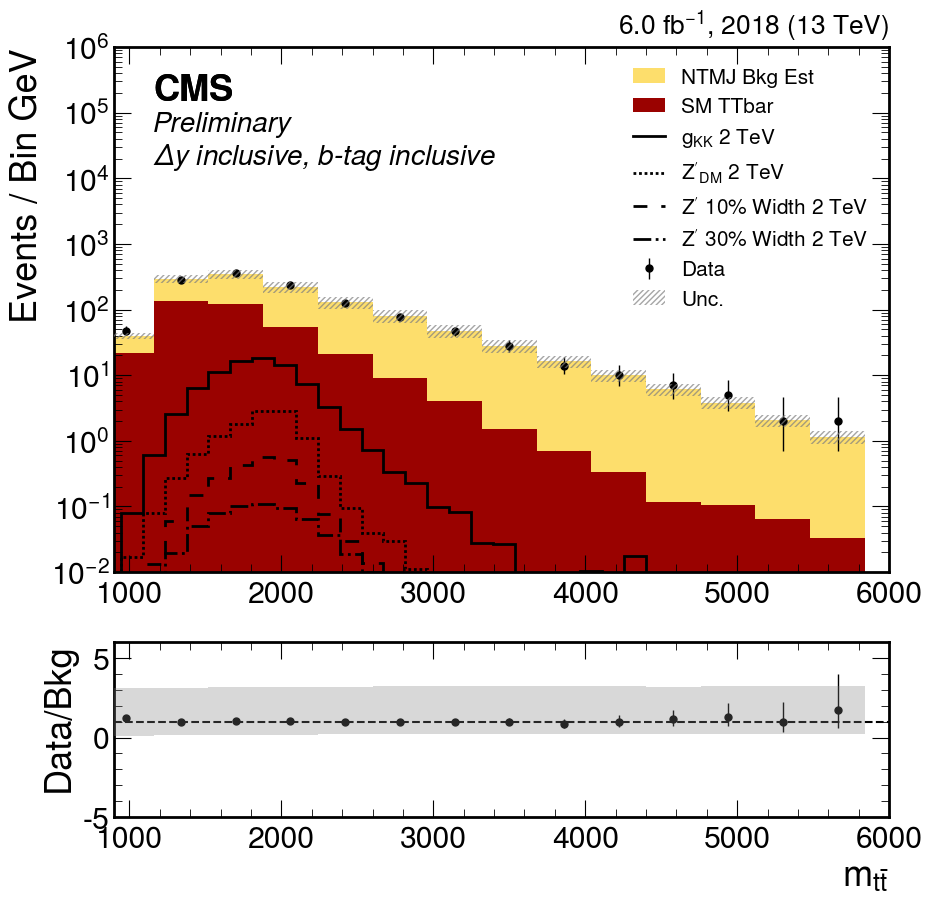

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


ttbar_str = IOV.replace('20','').replace('all','')

f = uproot.open(f'all_plots_{IOV.replace("all","")}.root')


signals = ['RSGluon2000', 'ZPrime2000_DM', 'ZPrime2000_10', 'ZPrime2000_30']
labels  = [r'$g_{KK}$ 2 TeV', r"$Z'_{DM}$ 2 TeV", r"$Z'$ 10% Width 2 TeV", r"$Z'$ 30% Width 2 TeV"]


hsigs = []
for signal in signals:

    hsigs.append(functions.getHist2('ttbarmass', signal, IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':signal_cats})
                )


hbkg0 = f['TotalBkg_Pass_postfit_projy0;1']
httbar0 = f[ttbar_str+'_TTbar_Pass_postfit_projy0;1']
hdata0 = f['data_obs_Pass_postfit_projy0;1']

hbkg1 = f['TotalBkg_Pass_postfit_projy1;1']
httbar1 = f[ttbar_str+'_TTbar_Pass_postfit_projy1;1']
hdata1 = f['data_obs_Pass_postfit_projy1;1']

hbkg2 = f['TotalBkg_Pass_postfit_projy2;1']
httbar2 = f[ttbar_str+'_TTbar_Pass_postfit_projy2;1']
hdata2 = f['data_obs_Pass_postfit_projy2;1']

hbkg_plots = hbkg0.to_hist() + hbkg1.to_hist() + hbkg2.to_hist()
httbar_plots = httbar0.to_hist() + httbar1.to_hist() + httbar2.to_hist()
hdata_plots = hdata0.to_hist() + hdata1.to_hist() + hdata2.to_hist()



# errors 
errs = np.sqrt(hbkg_plots.variances())

height = errs * 2
bottom = hbkg_plots.values() - errs
edges = hbkg_plots.axes['xaxis'].edges


text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hdata_plots, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hbkg_plots, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar_plots, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)


for i, h in enumerate(hsigs):
        
        ax1.stairs(h.values(), h.axes['ttbarmass'].edges, color='k', linestyle=lines[i], linewidth=2, label=labels[i])



ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
ratioUp = 1 + errs / hbkg_plots.values()
ratioDn = 1 - errs / hbkg_plots.values()


ax2.bar(x = edges[:-1],
           height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
           bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
           width = np.diff(edges), align='edge', edgecolor='gray',
           linewidth=0, facecolor='gray', alpha=0.3,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(-5,6)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend(fontsize=15)
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax2.set_xlabel(r'$m_{t\bar{t}}$')

ax1.set_yscale('log')
ax1.set_ylim(1e-2, 1e6)
ax1.set_xlim(900,6000)
ax2.set_xlim(900,6000)
ax1.set_xlabel('')


del f

    

## Transfer Function

In [8]:
qcd = util.load('../outputs/scale/QCD_2018.coffea')

# transfer function parameters
f = open(f'../data/corrections/rpf_params_QCD_rpf_fitb_3x1_2018.txt').read().split('\n')
params = {
    'param': [float(param.split('+/-')[0]) for param in [line.split(':')[1] for line in f]],
    'error': [float(param.split('+/-')[1]) for param in [line.split(':')[1] for line in f]],
    'function': '3x1',
}
del f

In [9]:
mttmt_sig = qcd['mtt_vs_mt'][{'systematic':'nominal', 'anacat':signal_cats}][{'anacat':sum}]
mttmt = qcd['mtt_vs_mt'][{'systematic':'nominal', 'anacat':antitag_cats}][{'anacat':sum}]

x = mttmt.axes.edges[0][:-1]
y = mttmt.axes.edges[1][:,:-1]
xx, yy = np.meshgrid(x, y)


xbinsize = 25
ybinsize = 360


# get bins of mt and mtt and x and y values
bins_mt  = np.arange(0,500,xbinsize) # 20 bins in mt
bins_mtt = np.arange(800,8000,ybinsize) # 20 bins in mtt
tx = (1/xbinsize) * bins_mt[(np.digitize(x, bins_mt) - 1)]
ty = (1/ybinsize) * bins_mtt[(np.digitize(y, bins_mtt) - 1)]


# get transfer function tf
tf = rpf(tx, ty, params['param'])

saving images/png/closureTest/2018/function.png
saving images/pdf/closureTest/2018/function.pdf


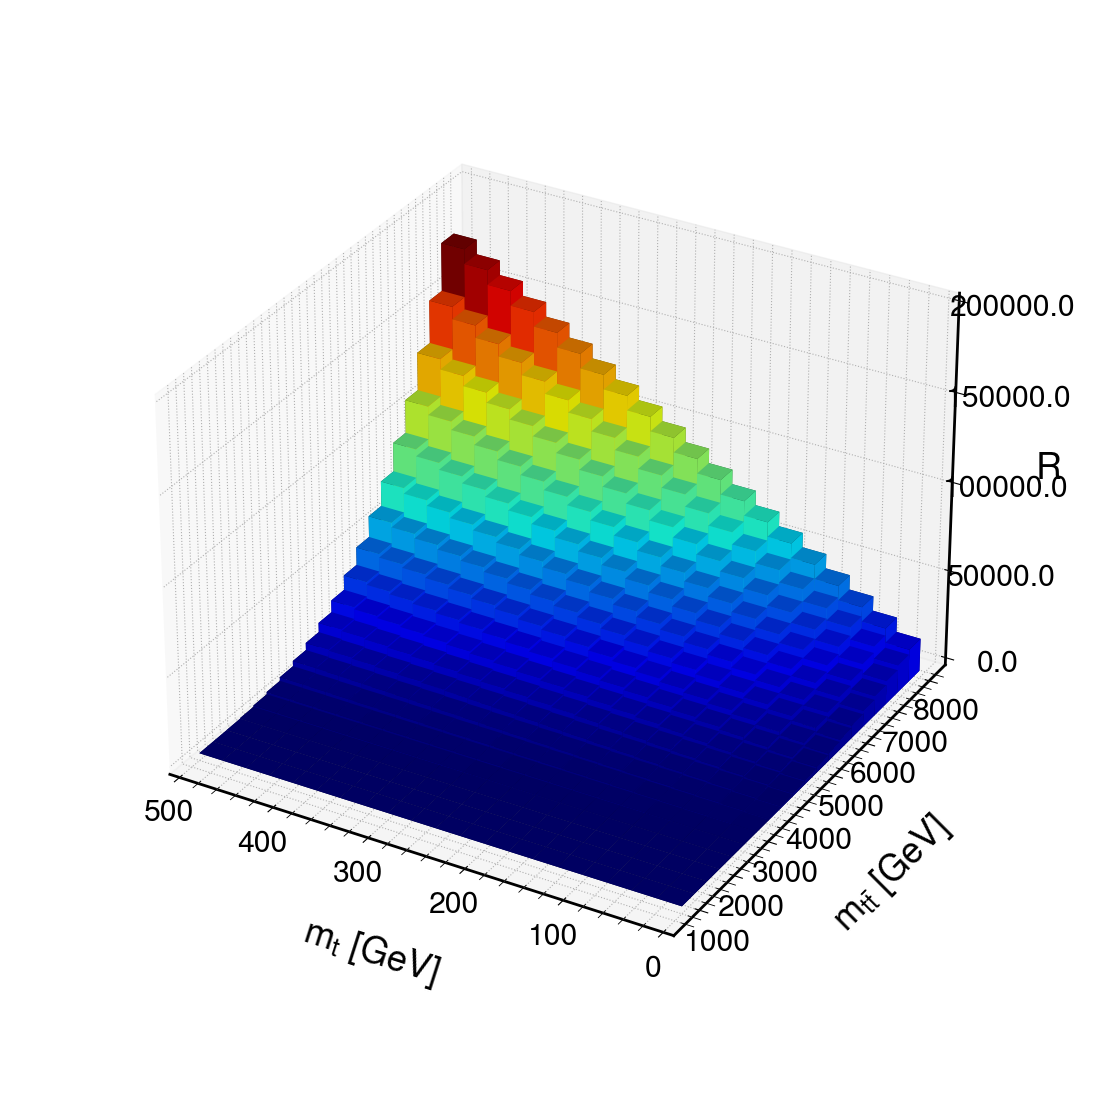

In [10]:
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(projection='3d')

# x = mt, y = mtt, z = transfer function
x = xx.flatten()
y = yy.flatten()
z = tf.flatten()

bottom = np.zeros_like(z)


# bin widths
dx = xbinsize
dy = ybinsize

cmap = plt.cm.get_cmap('jet')
hmax = np.max(z)
hmin = np.min(z)

rgba = [cmap((k-hmin)/hmax) for k in z] 

ax1.bar3d(x, y, bottom, dx, dy, z, color=rgba)
ax1.set_xlim(500,0)
ax1.set_zlim(1e-1,2e5)



ax1.tick_params(axis='z', which='major', pad=20)
ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel(r'$m_{t}$ [GeV]', labelpad=40, loc='right')
ax1.set_ylabel(r'$m_{t\bar{t}}$ [GeV]', labelpad=40)
ax1.set_zlabel(r'$R$', labelpad=30)
ax1.set_zticks(ax1.get_zticks()[::2])
ax1.set_zticklabels([str(z) for z in ax1.get_zticks()])


ax1.dist = 12


savefigname = f'images/png/closureTest/{IOV}/function.png'
plt.savefig(savefigname)
plt.savefig(savefigname.replace('png', 'pdf'))

print('saving '+savefigname)
print('saving '+savefigname.replace('png', 'pdf'))



## --- work in progress --- ##
## Closure Test 
### using bkgest from ttbarprocessor.py

Text(1, 0, '')

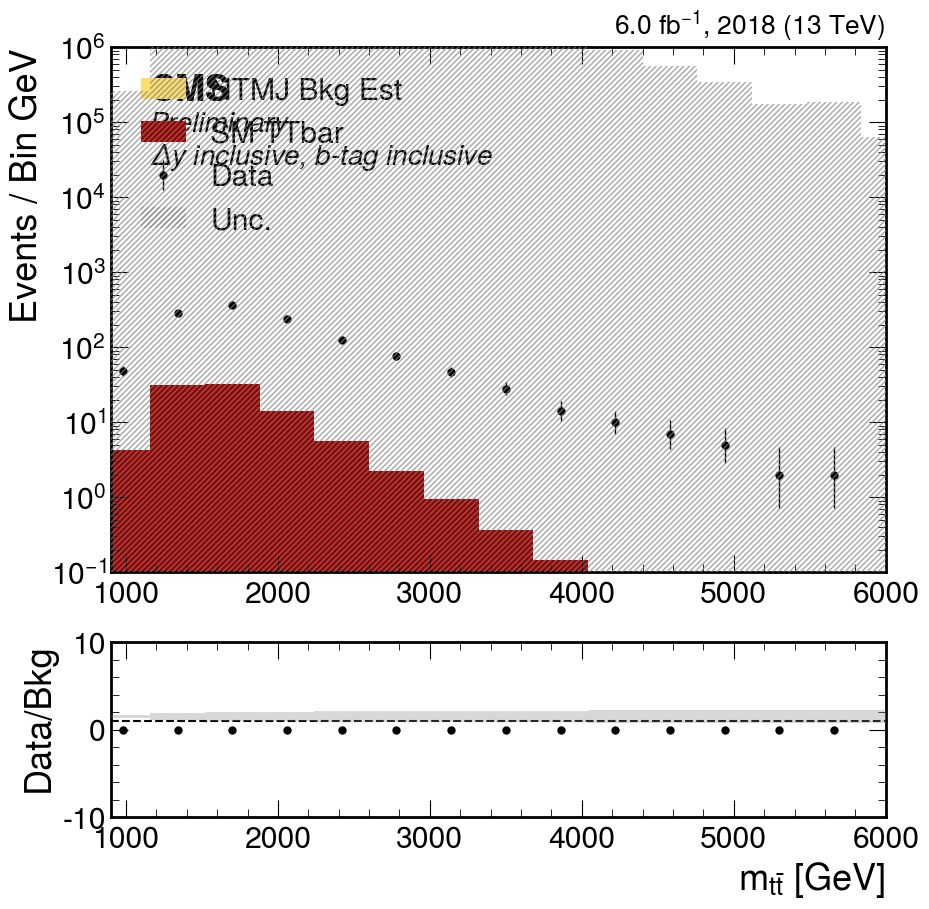

In [11]:

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])



hbkg = functions.getHist2('ttbarmass', 'JetHT', IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':antitag_cats},
         tag = '_bkgest'
        )

httbar = functions.getHist2('ttbarmass', 'TTbar', IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},        
        )

hsig = functions.getHist2('ttbarmass', 'JetHT', IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':signal_cats}        
        )


hUnc = functions.getHist2('ttbarmass', 'JetHT', IOV,
         sum_axes=['anacat'],
         integrate_axes={'anacat':antitag_cats},
         tag = '_bkgest')


hUp, hDn = getUncertainy(hbkg, hUnc)

text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hsig, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hbkg+httbar, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)

height = hUp.values() + hDn.values()
bottom = hbkg.values() - hDn.values()
edges  = hbkg.axes['ttbarmass'].edges


ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')


ratio_plot =  hsig / hbkg.values()
ratioUp = hUp.values() / hbkg.values()
ratioDn = hUp.values() / hbkg.values()


ax2.bar(x = edges[:-1],
           height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
           bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
           width = np.diff(edges), align='edge', edgecolor='gray',
           linewidth=0, facecolor='gray', alpha=0.3,
           zorder=10, label='Unc.')


ratio_plot =  hsig / hbkg.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(-10,10)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e6)
ax1.set_xlim(900,6000)
ax2.set_xlim(900,6000)
ax1.set_xlabel('')








## --- work in progress --- ##

## QCD Closure Test 
### using bkgest from ttbarprocessor.py

Text(1, 0, '')

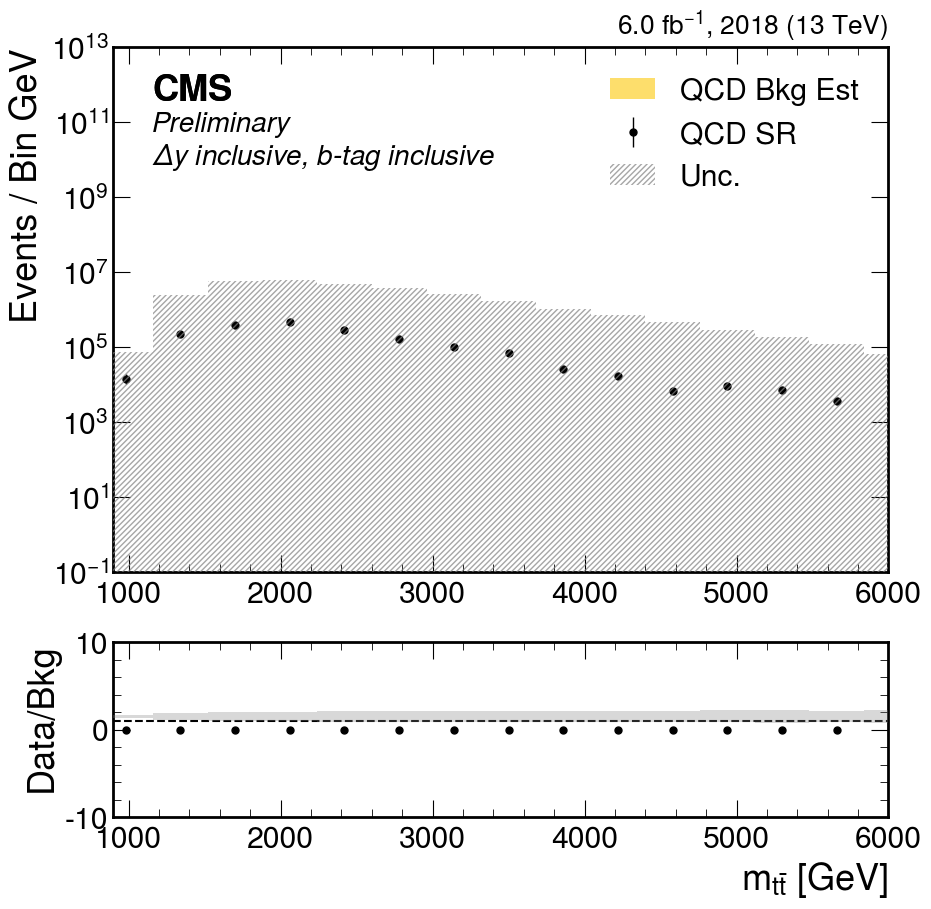

In [12]:
    fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

    hbkg = functions.getHist2('ttbarmass', 'QCD', IOV,
             sum_axes=['anacat'],
             integrate_axes={'systematic':'nominal', 'anacat':antitag_cats},
             tag = '_bkgest'

            )
    
    hsig = functions.getHist2('ttbarmass', 'QCD', IOV,
             sum_axes=['anacat'],
             integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
             tag = ''
            )

    # 2D histogram with all uncertainties for getting background uncertainty
    hUnc = functions.getHist2('ttbarmass', 'QCD', IOV,
             sum_axes=['anacat'],
             integrate_axes={'anacat':antitag_cats},
             tag = '_bkgest')


    hUp, hDn = getUncertainy(hbkg, hUnc)


    text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

    hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all','').replace('all',''), loc=2, fontsize=20, ax=ax1)
    hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

    hep.histplot(hsig, histtype='errorbar', color='black', label='QCD SR', ax=ax1)
    hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='QCD Bkg Est', ax=ax1)
    herr = np.sqrt(hbkg.variances())

    height = hUp.values() + hDn.values()
    bottom = hbkg.values() - hDn.values()
    edges  = hbkg.axes['ttbarmass'].edges


    ax1.bar(x = edges[:-1],
               height=height,
               bottom=bottom,
               width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
               linewidth=0, facecolor='none', alpha=0.7,
               zorder=10, label='Unc.')


    ratio_plot =  hsig / hbkg.values()
    ratioUp = hUp.values() / hbkg.values()
    ratioDn = hUp.values() / hbkg.values()


    ax2.bar(x = edges[:-1],
               height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
               bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
               width = np.diff(edges), align='edge', edgecolor='gray',
               linewidth=0, facecolor='gray', alpha=0.3,
               zorder=10, label='Unc.')

    hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
    ax2.set_ylim(-10,10)
    ax2.axhline(1, color='black', ls='--')
    ax2.set_ylabel('Data/Bkg')


    ax1.legend()
    ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
    ax1.set_yscale('log')
    ax1.set_ylim(1e-1, 1e13)
    ax1.set_xlim(900,6000)
    ax2.set_xlim(900,6000)
    ax1.set_xlabel('')